Raw CSV columns: ['date', 'Ex_rate']
Columns after setting date index: ['Ex_rate']
Only one data column found. Using 'Ex_rate' as target.

Selected series: 'Ex_rate' with 7588 rows.
Frequency could not be inferred. Continuing without setting freq.

--- Quick stats ---


count    7588.000000
mean        0.776974
std         0.136620
min         0.483297
25%         0.701422
50%         0.761377
75%         0.873477
max         1.102536
Name: Ex_rate, dtype: float64

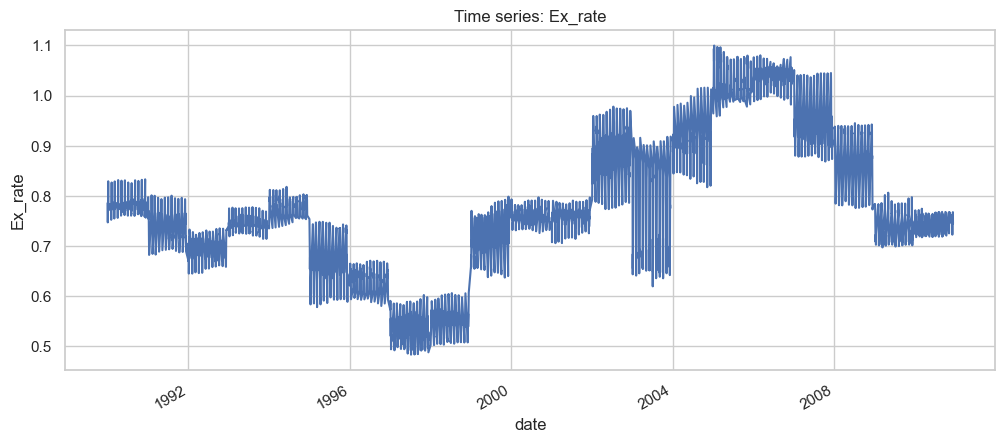

Missing values: 0

ADF Statistic: -2.4371548684089603 p-value: 0.13152308269518942
Suggested differencing (d): 1


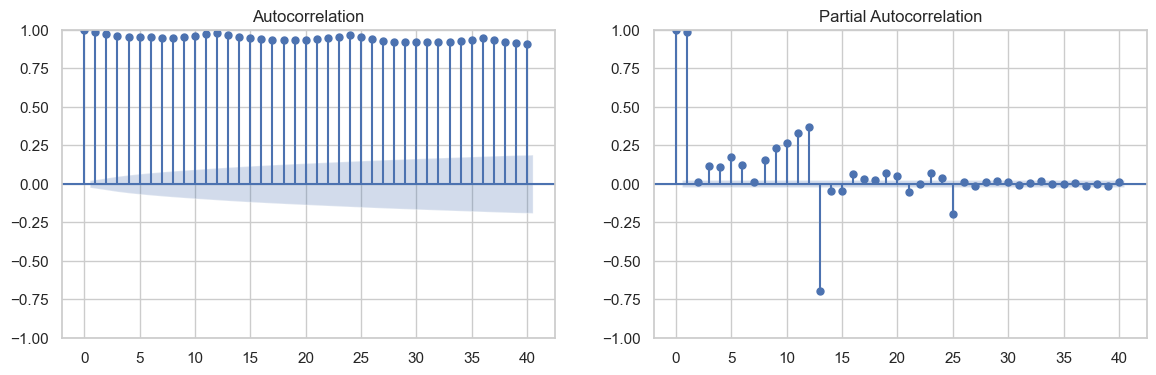


Train size: 6071, Test size: 1517

--- ARIMA modelling ---
pmdarima not installed; using default order: (1, 1, 1)
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.6750      0.011     64.217      0.000       0.654       0.696
ma.L1         -0.9221      0.006   -148.570      0.000      -0.934      -0.910
sigma2         0.0006   4.76e-06    122.427      0.000       0.001       0.001


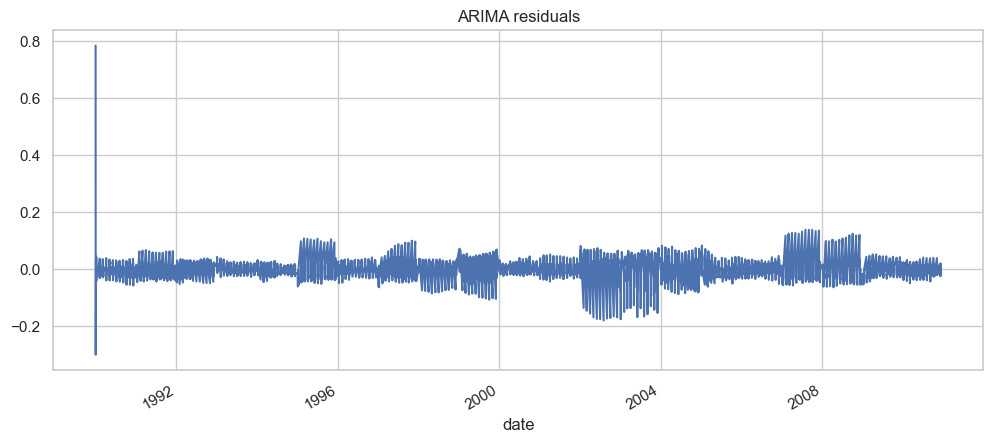


--- Holt-Winters ---


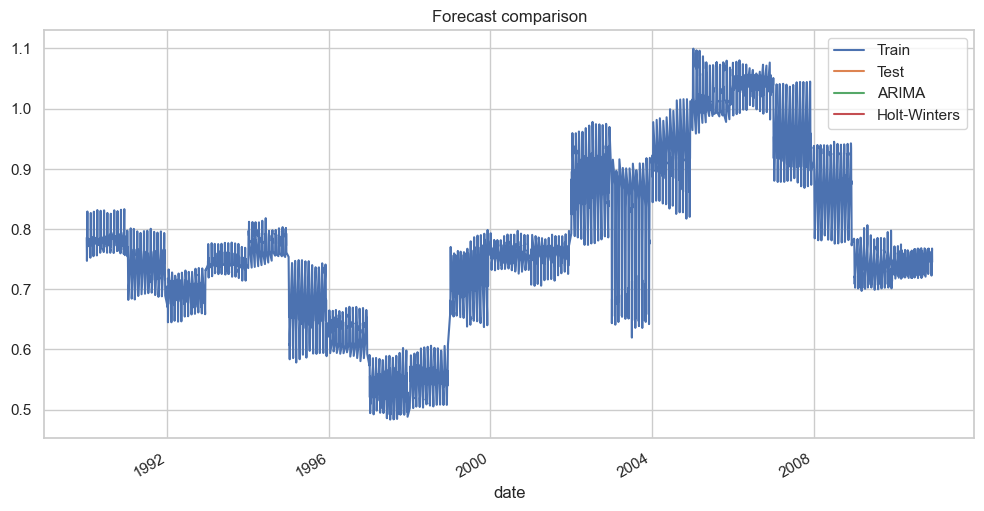


--- Forecast metrics ---
ARIMA MAE: 0.097269, RMSE: 0.114979, MAPE: 11.222%
Holt-Winters MAE: 0.105306, RMSE: 0.130423, MAPE: 12.715%

ARIMA residual diagnostics


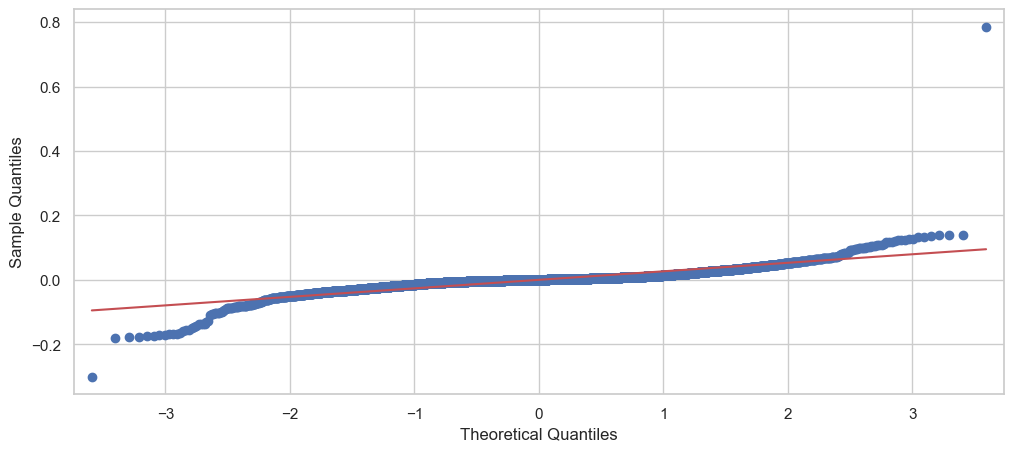

Ljung-Box (lag 10):


,lb_stat,lb_pvalue
10,312.845258,2.983175e-61


Saved forecasts to: ts_forecast_outputs\forecasts_Ex_rate.csv

CONCLUSION:
ARIMA performed better on RMSE.
Done.


In [4]:
#Robust Time Series Forecasting: ARIMA & Holt-Winters
import warnings
warnings.filterwarnings("ignore")
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_error, mean_squared_error
from statsmodels.graphics.gofplots import qqplot
from statsmodels.stats.diagnostic import acorr_ljungbox

# Optional auto_arima
try:
    from pmdarima import auto_arima
    HAS_PMD = True
except:
    HAS_PMD = False

plt.rcParams["figure.figsize"] = (12,5)

# ----------- CONFIG: your path -----------
csv_path = r"C:\Users\abhin\Downloads\exchange_rate (1).csv"   # <-- your file
# set desired target by index (0-based) or name; we'll handle out-of-range automatically
desired_target_col_index = 1   # you intended second column; if not present we'll pick a fallback
date_col_index = 0             # first column used as date
freq = None
test_size = 0.2
seasonal_periods = None

# ----------- helper metrics -----------
def mape(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    mask = y_true != 0
    return np.mean(np.abs((y_true[mask] - y_pred[mask]) / y_true[mask])) * 100
def print_metrics(y_true, y_pred, prefix=""):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mkp = mape(y_true, y_pred)
    print(f"{prefix} MAE: {mae:.6f}, RMSE: {rmse:.6f}, MAPE: {mkp:.3f}%")
    return {"MAE": mae, "RMSE": rmse, "MAPE": mkp}

# ----------- Load file and inspect columns -----------
path = Path(csv_path)
if not path.exists():
    raise FileNotFoundError(f"CSV not found at: {csv_path}\nPlease check the path.")

df = pd.read_csv(path, header=0)
print("Raw CSV columns:", list(df.columns))

# Parse date column (date_col_index)
date_col_name = df.columns[date_col_index]
df[date_col_name] = pd.to_datetime(df[date_col_name], errors='coerce')
df = df.set_index(date_col_name).sort_index()

# After setting index, show remaining columns
print("Columns after setting date index:", list(df.columns))

# Determine target column robustly
if isinstance(desired_target_col_index, int):
    if 0 <= desired_target_col_index < len(df.columns):
        target_name = df.columns[desired_target_col_index]
        print(f"Using target column by index: df.columns[{desired_target_col_index}] -> '{target_name}'")
    else:
        # fallback choices: try 2nd column if exists, else first column
        if len(df.columns) >= 2:
            target_name = df.columns[1]
            print(f"Desired index {desired_target_col_index} is out of range. Falling back to second column: '{target_name}'")
        elif len(df.columns) == 1:
            target_name = df.columns[0]
            print(f"Only one data column found. Using '{target_name}' as target.")
        else:
            raise ValueError("No data columns found after setting the date index.")
else:
    # desired_target_col_index might be a name string
    if desired_target_col_index in df.columns:
        target_name = desired_target_col_index
        print(f"Using target column by name: '{target_name}'")
    else:
        raise ValueError(f"Specified target column name '{desired_target_col_index}' not found in columns: {list(df.columns)}")

# Extract series
y = df[target_name].astype(float).copy()
print(f"\nSelected series: '{target_name}' with {len(y)} rows.")

# Infer frequency
if freq is None:
    try:
        freq = pd.infer_freq(y.index)
    except:
        freq = None
if freq is not None:
    print("Inferred frequency:", freq)
    y = y.asfreq(freq)
else:
    print("Frequency could not be inferred. Continuing without setting freq.")

# Quick EDA
print("\n--- Quick stats ---")
display(y.describe())
y.plot(title=f"Time series: {target_name}")
plt.ylabel(target_name)
plt.show()

# Fill missing
n_missing = y.isna().sum()
print("Missing values:", n_missing)
if n_missing > 0:
    y = y.fillna(method='ffill').fillna(method='bfill')
    print("Filled missing values (ffill then bfill).")

# Stationarity test
from statsmodels.tsa.stattools import adfuller
adf_res = adfuller(y.dropna())
print("\nADF Statistic:", adf_res[0], "p-value:", adf_res[1])
d = 0 if adf_res[1] < 0.05 else 1
print("Suggested differencing (d):", d)

# ACF/PACF plots
fig, ax = plt.subplots(1,2, figsize=(14,4))
plot_acf(y.dropna(), ax=ax[0], lags=40)
plot_pacf(y.dropna(), ax=ax[1], lags=40, method='ywm')
plt.show()

# Train/test split
n_test = int(len(y) * test_size)
if n_test == 0:
    raise ValueError("Test set size computed as 0. Increase test_size or provide more data.")
y_train, y_test = y.iloc[:-n_test], y.iloc[-n_test:]
print(f"\nTrain size: {len(y_train)}, Test size: {len(y_test)}")

# ARIMA modelling (auto if pmdarima present)
print("\n--- ARIMA modelling ---")
try:
    from pmdarima import auto_arima
    HAS_PMD = True
except:
    HAS_PMD = False

if HAS_PMD:
    print("Running auto_arima (this may take a while)...")
    ar = auto_arima(y_train, seasonal=False, stepwise=True, error_action='ignore', suppress_warnings=True, max_p=5, max_q=5)
    order = ar.order
    print("auto_arima suggested order:", order)
else:
    order = (1, d, 1)
    print("pmdarima not installed; using default order:", order)

model_arima = SARIMAX(y_train, order=order, enforce_stationarity=False, enforce_invertibility=False)
res_arima = model_arima.fit(disp=False)
print(res_arima.summary().tables[1])

# Forecast & residuals
h = len(y_test)
forecast_arima = res_arima.get_forecast(steps=h)
pred_arima = forecast_arima.predicted_mean
pred_arima.index = y_test.index

resid = res_arima.resid
plt.figure(); resid.plot(title="ARIMA residuals"); plt.show()

# Holt-Winters
print("\n--- Holt-Winters ---")
if seasonal_periods is None and freq and 'M' in str(freq):
    seasonal_periods = 12

if seasonal_periods:
    model_hw = ExponentialSmoothing(y_train, trend="add", seasonal="add", seasonal_periods=seasonal_periods)
else:
    model_hw = ExponentialSmoothing(y_train, trend="add", seasonal=None)

res_hw = model_hw.fit(optimized=True)
pred_hw = res_hw.forecast(h)
pred_hw.index = y_test.index

# Plot forecasts
plt.figure(figsize=(12,6))
y_train.plot(label="Train")
y_test.plot(label="Test")
pred_arima.plot(label="ARIMA")
pred_hw.plot(label="Holt-Winters")
plt.legend(); plt.title("Forecast comparison"); plt.show()

# Metrics
print("\n--- Forecast metrics ---")
metrics_arima = print_metrics(y_test, pred_arima, prefix="ARIMA")
metrics_hw = print_metrics(y_test, pred_hw, prefix="Holt-Winters")

# Residual diagnostics
print("\nARIMA residual diagnostics")
qqplot(resid.dropna(), line='s'); plt.show()
print("Ljung-Box (lag 10):")
display(acorr_ljungbox(resid.dropna(), lags=[10], return_df=True))

# Save results
out = Path("ts_forecast_outputs")
out.mkdir(exist_ok=True)
pred_df = pd.DataFrame({"y_test": y_test, "pred_arima": pred_arima, "pred_hw": pred_hw})
pred_df.to_csv(out / f"forecasts_{target_name}.csv", index=True)
print("Saved forecasts to:", out / f"forecasts_{target_name}.csv")

# Conclusion
print("\nCONCLUSION:")
if metrics_arima["RMSE"] < metrics_hw["RMSE"]:
    print("ARIMA performed better on RMSE.")
else:
    print("Holt-Winters performed better on RMSE.")
print("Done.")